In [91]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 8.551577 ,  9.611249 ,  9.645458 , 10.504453 ,  7.9374313,
        8.283738 , 10.939752 ,  8.38234  ,  9.912931 , 12.196817 ,
        8.223717 , 10.179745 ], dtype=float32)

In [93]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [94]:
run_path = random.choice(run_paths)
chunks_range = range(SEQ_LEN-1, 1160, SEQ_LEN)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 100, 80, 3),
 '/home/beans/blender_membank/dataloader_11/run_22')

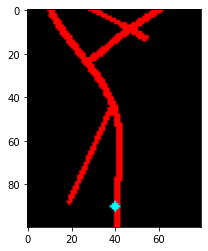

In [95]:
plt.imshow(maps[550])

In [96]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

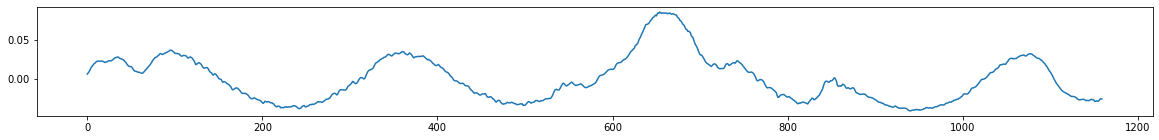

In [97]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

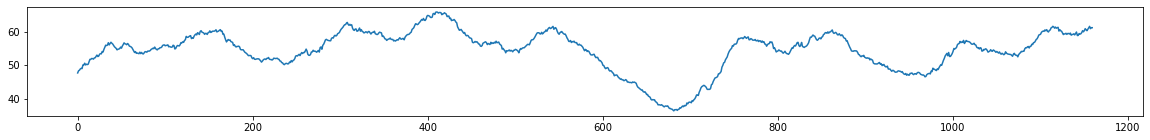

In [98]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [99]:
ix = 600

In [100]:
t = smooth_near_wps(targets[ix])

In [101]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [102]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

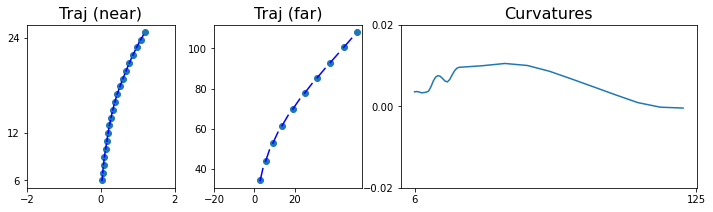

In [103]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

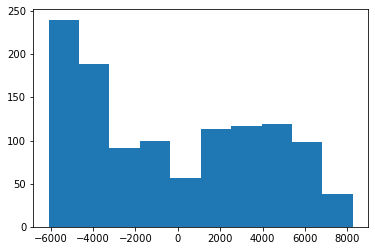

In [104]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

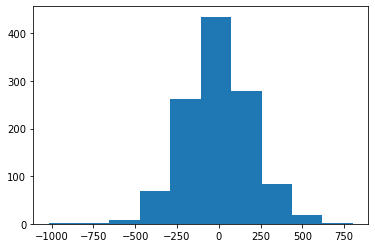

In [105]:
plt.hist(torque[1:]-torque[:-1])[2]

In [106]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [107]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-80:,:] = np.fliplr(maps[i])
    
    video.write(img)
    
video.release()

In [108]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-80:,:] = np.fliplr(maps[i])

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "8.18_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [19]:
combine_vids("8.9_avg", "8.9_avgTrain", "sim")

combined!


In [267]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [23]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 165.,  323.,  368.,  670.,  868., 1164., 1025.,  626.,  446.,
         145.]),
 array([-0.06666353, -0.05459857, -0.04253361, -0.03046865, -0.01840369,
        -0.00633873,  0.00572622,  0.01779118,  0.02985614,  0.0419211 ,
         0.05398606], dtype=float32),
 <BarContainer object of 10 artists>)

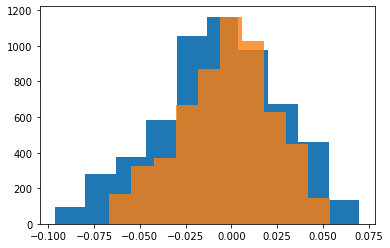

In [24]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

(array([ 79., 325., 488., 731., 949., 890., 794., 910., 536.,  98.]),
 array([-0.09078395, -0.07428899, -0.05779405, -0.0412991 , -0.02480415,
        -0.0083092 ,  0.00818575,  0.0246807 ,  0.04117565,  0.0576706 ,
         0.07416555], dtype=float32),
 <BarContainer object of 10 artists>)

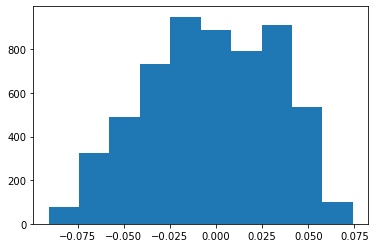

In [162]:
obsnet_outs.shape

(1160, 3)

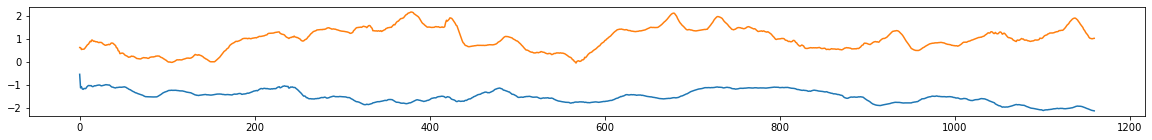

In [163]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [164]:
aux[0]

array([-1.5071025e+00,  6.1787933e-01,  3.4964561e+01,  0.0000000e+00,
       -3.0346576e-03], dtype=float32)

In [11]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [12]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 6.87 s, sys: 7.39 ms, total: 6.88 s
Wall time: 6.87 s


In [13]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [14]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((348, 1160, 30), (348, 1160, 30), (348, 1160, 30), (348, 1160, 30))

<BarContainer object of 40 artists>

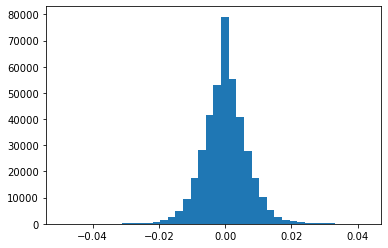

In [15]:
plt.hist(all_curvatures[:,:,2].flatten(), bins=40)[2]

In [16]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

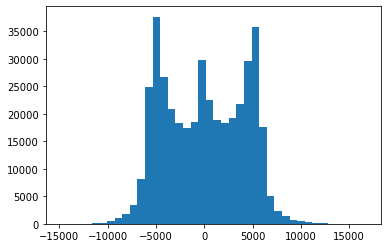

In [17]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

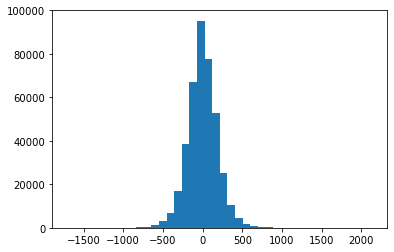

In [18]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [19]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(871.6071982324232, 11248.956656865868)

In [20]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.995307 ,   6.9944797,   7.993593 ,   8.992666 ,   9.991619 ,
        10.990543 ,  11.989374 ,  12.9880705,  13.986692 ,  14.985165 ,
        15.983565 ,  16.981771 ,  17.97983  ,  18.977749 ,  19.975433 ,
        20.97298  ,  21.970394 ,  22.967583 ,  23.964558 ,  24.961348 ,
        34.917824 ,  44.850784 ,  54.75804  ,  64.63755  ,  74.48968  ,
        84.31575  ,  94.116875 , 103.89416  , 113.648346 , 123.38047  ],
      dtype=float32)

<BarContainer object of 40 artists>

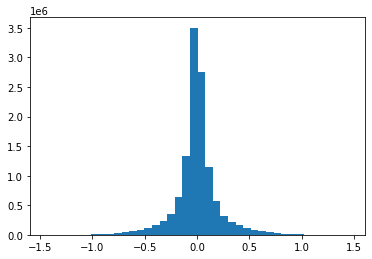

In [21]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [22]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02751925, 0.03185285, 0.03612231, 0.04039437, 0.04466409,
       0.04892576, 0.05316894, 0.05740896, 0.06165808, 0.06592117,
       0.07017051, 0.0743417 , 0.0784355 , 0.08246395, 0.08644363,
       0.09039721, 0.09434728, 0.09828313, 0.10218173, 0.10598195,
       0.14248349, 0.17658845, 0.20672831, 0.23270887, 0.25491244,
       0.27392054, 0.2899704 , 0.30324176, 0.31392393, 0.3192949 ],
      dtype=float32)

In [23]:
mean_headings[-1] / mean_headings[0]

11.6026

In [24]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01715851, 0.01891547, 0.02077115, 0.02268982, 0.02465182,
       0.02664448, 0.02865766, 0.0306845 , 0.03272223, 0.03476865,
       0.03682245, 0.03887746, 0.04092604, 0.04296553, 0.04499373,
       0.04701224, 0.04902306, 0.05102745, 0.0530253 , 0.05501508,
       0.07446483, 0.09294023, 0.11018317, 0.12595287, 0.14023148,
       0.15307982, 0.16454582, 0.17474484, 0.18377276, 0.19166444],
      dtype=float32)

In [25]:
mean_angles[-1] / mean_angles[0]

11.170228

In [26]:
mean_angles[0] / .015

1.1439005533854167

<BarContainer object of 40 artists>

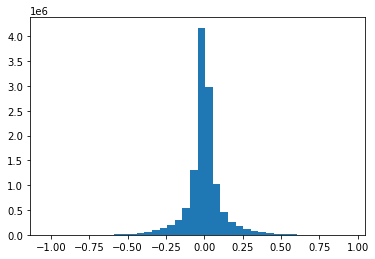

In [27]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

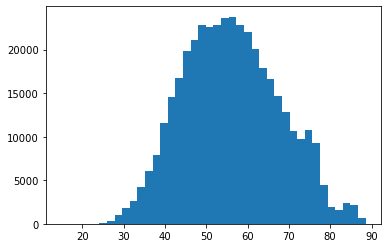

In [28]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

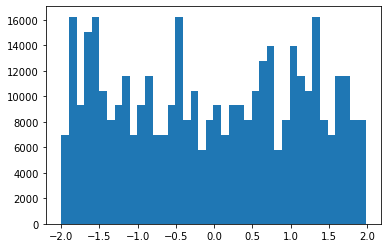

In [29]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

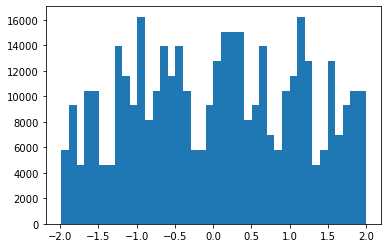

In [30]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]